In [1]:
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
start_date = '2010-01-01'
tickers = pd.read_csv('./data/tickers.csv')['tickers'].tolist()
print(f'Number of stocks: {len(tickers)}')

Number of stocks: 389


# Implement Strategy

In [30]:
class MomStrategy(bt.Strategy):
    # use lookback period as 12 Business Month
    params = (
        ('period', 12*20),
        ('top_quintile', 10),
    )
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.month_year = []
        self.vnindex = self.datas[0]
        self.stocks = self.datas[1:]
        self.inds = {}
        
        for d in self.stocks:
            self.inds[d] = {}
            self.inds[d]["mom"] = bt.indicators.Momentum(d.close, period=self.p.period)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    def prenext(self):
        # call next() even when data is not available for all tickers
        self.next()
    
    def next(self):
        current_date = self.datas[0].datetime.date(0)
        current_month = f'{current_date.year}{current_date.month}'
        if current_month not in self.month_year:
            self.rebalance()
            self.month_year.append(current_month)
    
    @property
    def open_positions(self):
        return list(filter(lambda d: self.getposition(d).size > 0, self.broker.positions))
    
    def rebalance(self):
        self.rankings = list(filter(lambda d: len(d) > 100, self.stocks))
        self.rankings.sort(key=lambda d: self.inds[d]["mom"][0], reverse=True)
        num_stocks = len(self.rankings)
        
        # close all positions
        for i, d in enumerate(self.open_positions):
            self.close(d)
        
        portfolio_value = self.broker.get_value()
        weight = 1 / self.p.top_quintile
        for i, d in enumerate(self.rankings[:int(self.p.top_quintile)]):
            size = int(portfolio_value * weight / d.close[0])
            self.buy(d, size=size)

In [31]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)

# Adding a Data Feed


In [32]:
vnindex_df = pd.read_csv(f"data/VNINDEX.csv",
                             parse_dates=True,
                             index_col=['date'])

vnindex_df.dropna(inplace=True)
date_range = (vnindex_df.index >= start_date)
vnindex = bt.feeds.PandasData(dataname=vnindex_df[date_range], plot=False)
cerebro.adddata(vnindex, name='vnindex')  # add VNIndex
cerebro.addanalyzer(bt.analyzers.TimeReturn, data=vnindex, _name='benchmark')
cerebro.addanalyzer(bt.analyzers.TimeReturn)

for ticker in tickers:
    df = pd.read_csv(f"data/{ticker}.csv",
                     parse_dates=True,
                     index_col=['timestamp'])

    df.dropna(inplace=True)
    if len(df) > 12*20:  # data must be long enough to compute 12 months
        date_range = (df.index >= start_date)
        cerebro.adddata(bt.feeds.PandasData(dataname=df[date_range], plot=False), name=ticker)

# Add analyzers and observers

In [33]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.addstrategy(MomStrategy)

results = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2010-07-02, BUY EXECUTED, Price: 10.33, Cost: 10032.37, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 15.23, Cost: 9990.88, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 10.12, Cost: 9298.44, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 6.07, Cost: 10105.47, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 13.69, Cost: 10062.15, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 5.15, Cost: 9999.36, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 7.86, Cost: 10093.52, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 7.81, Cost: 10231.10, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 23.71, Cost: 9983.59, Comm 0.00
2010-07-02, BUY EXECUTED, Price: 14.18, Cost: 10052.91, Comm 0.00
2010-08-03, SELL EXECUTED, Price: 9.94, Cost: 10032.37, Comm 0.00
2010-08-03, SELL EXECUTED, Price: 15.68, Cost: 9990.88, Comm 0.00
2010-08-03, SELL EXECUTED, Price: 11.43, Cost: 9298.44, Comm 0.00
2010-08-03, SELL EXECUTED, Price: 6.11, Cost: 10105.47, Comm 0.00
2010-08-03, SELL EXECUTED, Price: 12.37, Cost: 1

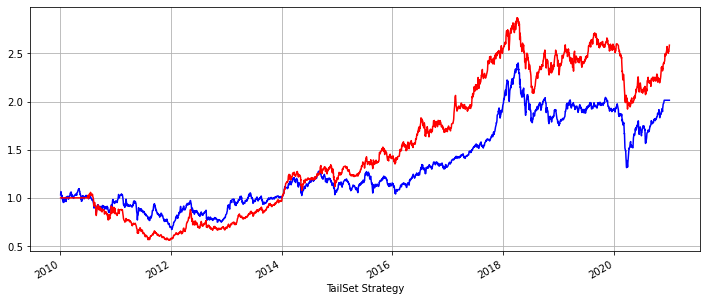

In [34]:
# If no name has been specified, the name is the class name lowercased
benchmark_analyzer = results[0].analyzers.getbyname('benchmark')
return_analyzer = results[0].analyzers.getbyname('timereturn')
# print(tret_analyzer.get_analysis())
benchmark = pd.Series(benchmark_analyzer.get_analysis(), name='benchmark')
cum_benchmark = (1 + benchmark).cumprod()
account_return = pd.Series(return_analyzer.get_analysis(), name='return')
cum_r = (1 + account_return).cumprod()
df = pd.concat([cum_r, cum_benchmark], axis=1)

plt.figure(figsize=(12, 5))
plt.xlabel('TailSet Strategy')

ax1 = df.benchmark.plot(color='blue', grid=True, label='benchmark')
ax2 = df['return'].plot(color='red', grid=True, label='return')

ax1.plot()
ax2.plot()
plt.show()

In [35]:
strat0 = results[0]
pyfoliozer = strat0.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

d:\trading\empyrical\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)
d:\trading\pyfolio\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'
d:\trading\pyfolio\pyfolio\utils.py:299: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  '=False to disable.')


Start date,2010-01-04
End date,2020-12-31
Total months,130
,Backtest
Annual return,9.114%
Cumulative returns,158.518%
Annual volatility,18.298%
Sharpe ratio,0.57
Calmar ratio,0.19
Stability,0.84
Max drawdown,-47.039%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,47.04,2010-07-20,2011-12-21,2014-01-16,913
1,33.05,2018-04-02,2020-03-30,NaT,NaN
2,16.97,2014-11-20,2014-12-17,2015-06-18,151
3,15.45,2014-04-14,2014-05-13,2014-09-11,109
4,11.45,2015-10-30,2016-01-18,2016-03-02,89


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.36%,-3.27%,3.56%
EZB IR Event,-0.08%,-2.24%,2.00%
Flash Crash,0.00%,0.00%,0.00%


Top 10 long positions of all time,max
sid,
BMP,76108.82%
ABT,75836.55%
CII,75063.00%
ACC,74524.38%
DSN,26536.38%
DVP,26301.04%
TCT,20398.21%
PVD,19864.36%
ACL,17067.83%


Top 10 short positions of all time,max
sid,
DSN,-74580.62%
AAM,-73638.15%
CIG,-73053.59%
CNG,-72477.16%
BSI,-70803.68%
C32,-31694.78%
BMC,-20668.09%
BTT,-20223.00%
CSM,-19345.44%


Top 10 positions of all time,max
sid,
BMP,76108.82%
ABT,75836.55%
CII,75063.00%
DSN,74580.62%
ACC,74524.38%
AAM,73638.15%
CIG,73053.59%
CNG,72477.16%
BSI,70803.68%


C:\Users\Admin\anaconda3\envs\mlfin\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\Admin\anaconda3\envs\mlfin\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


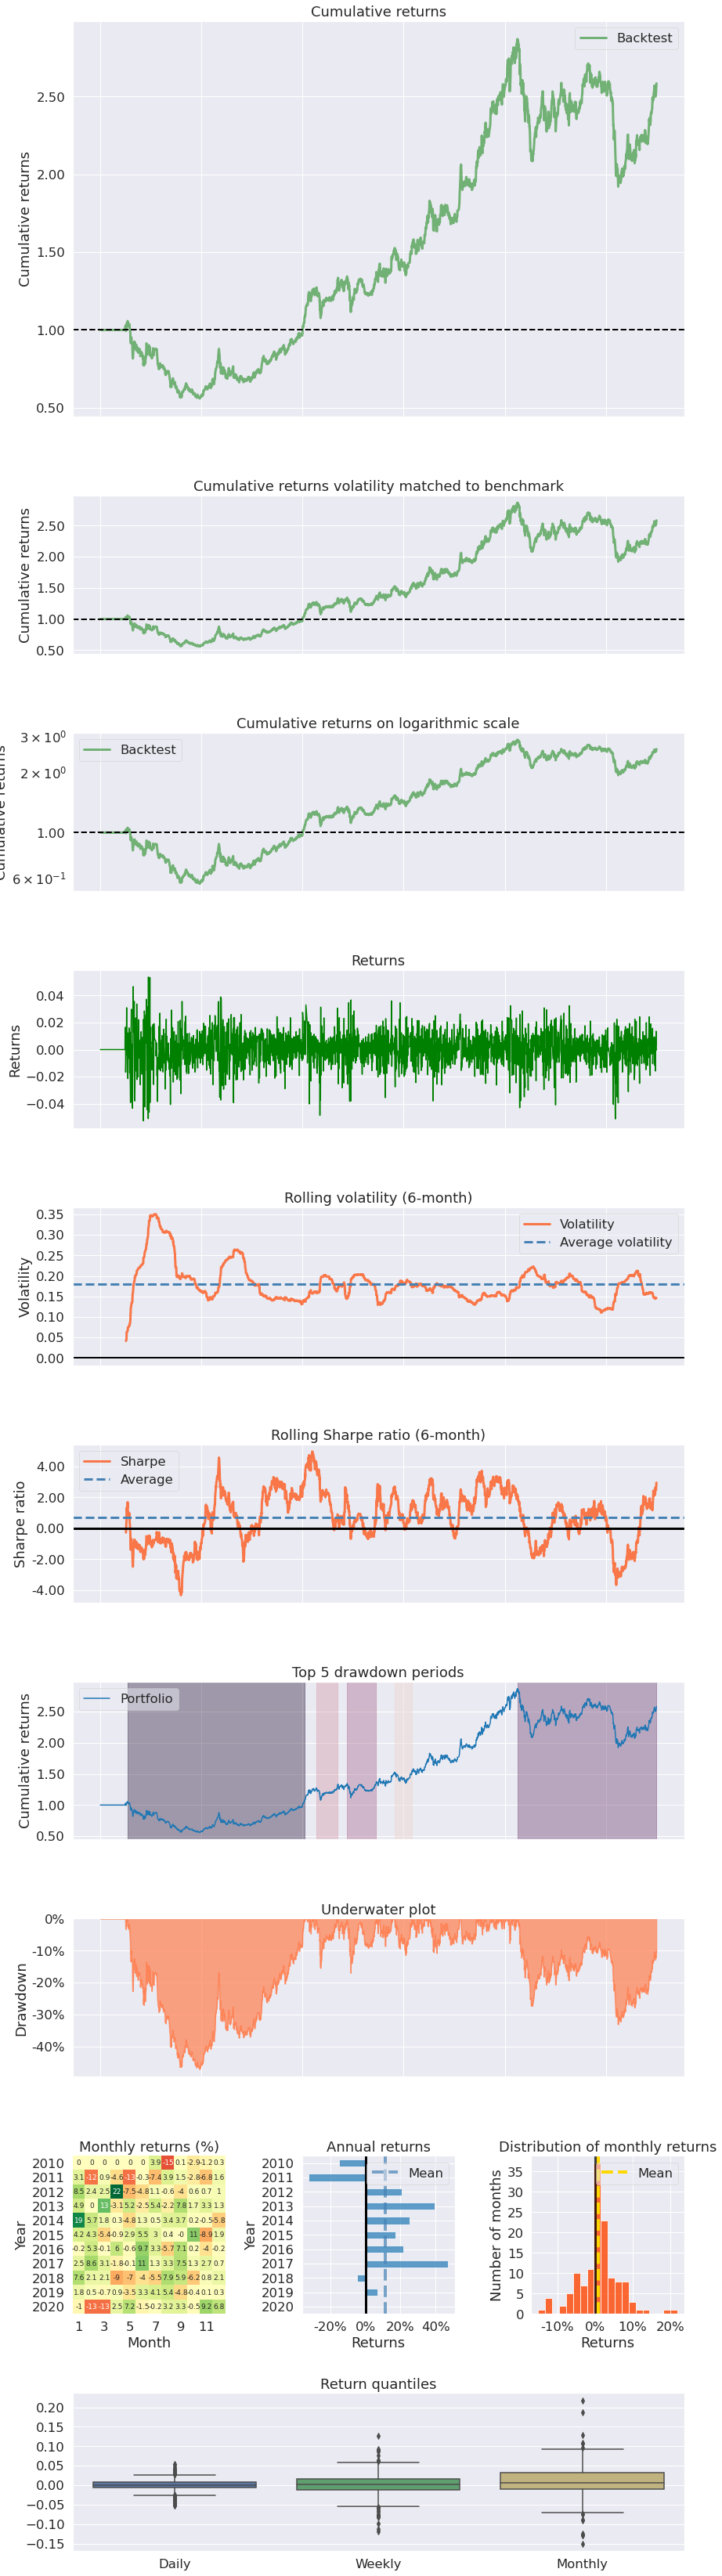

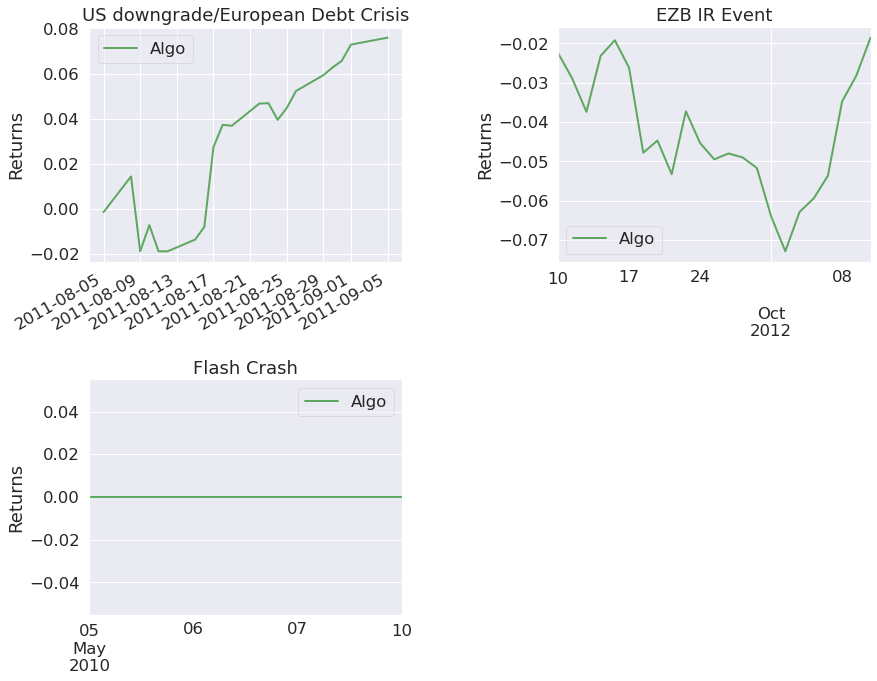

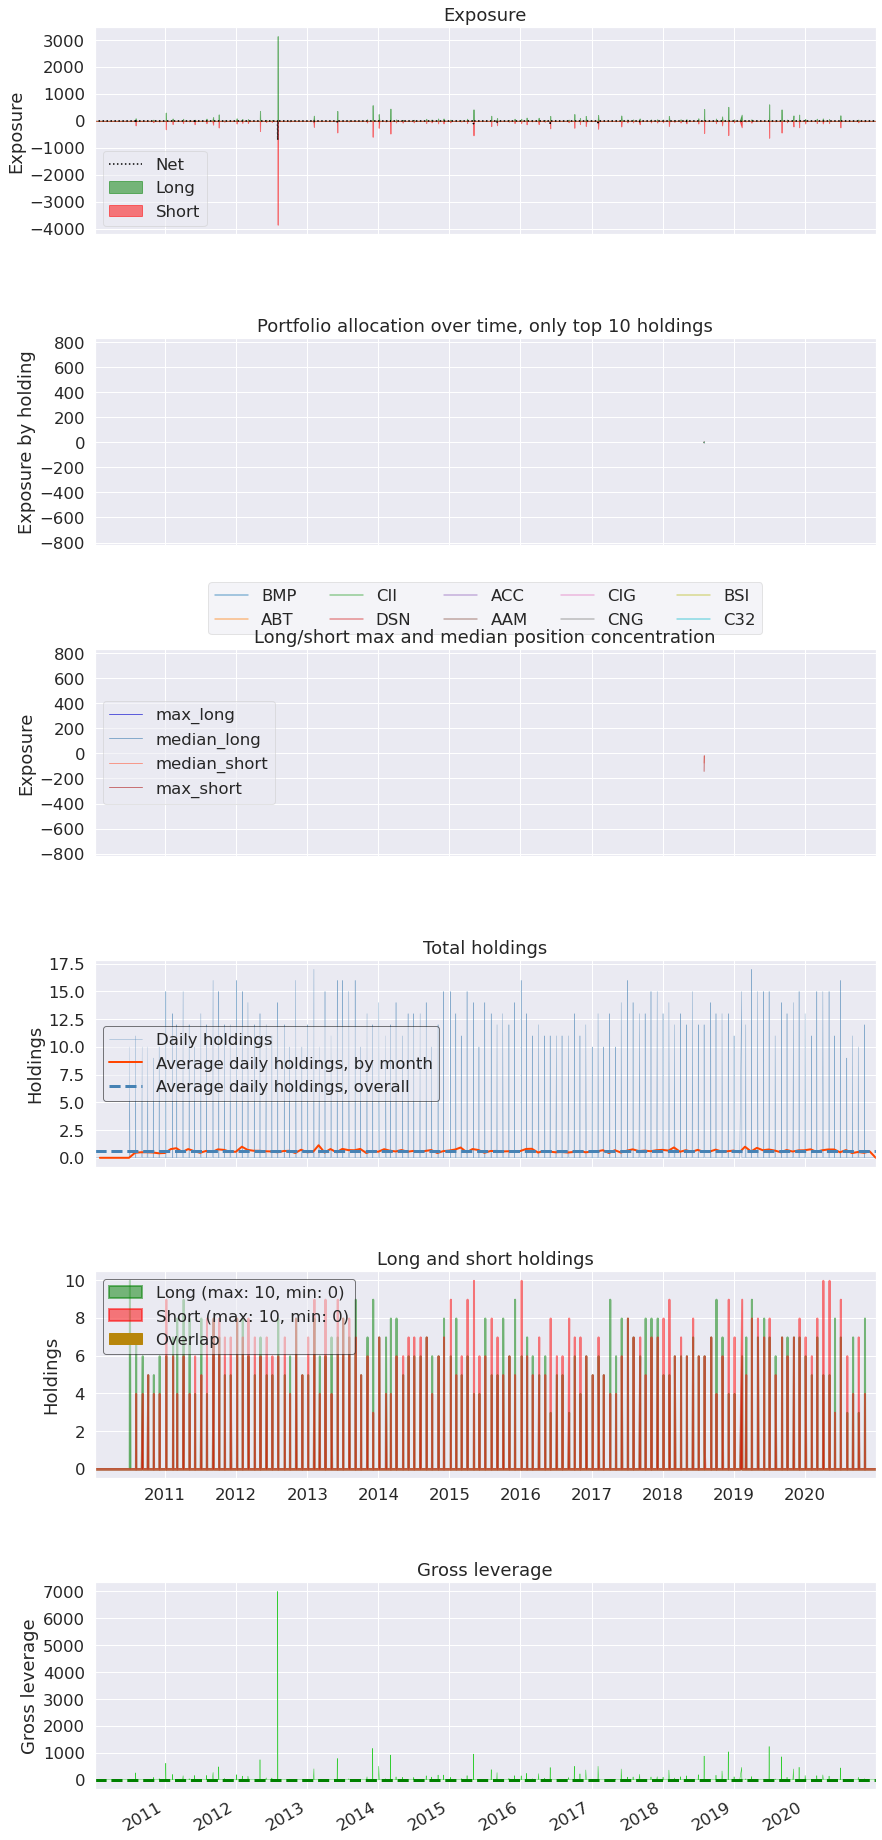

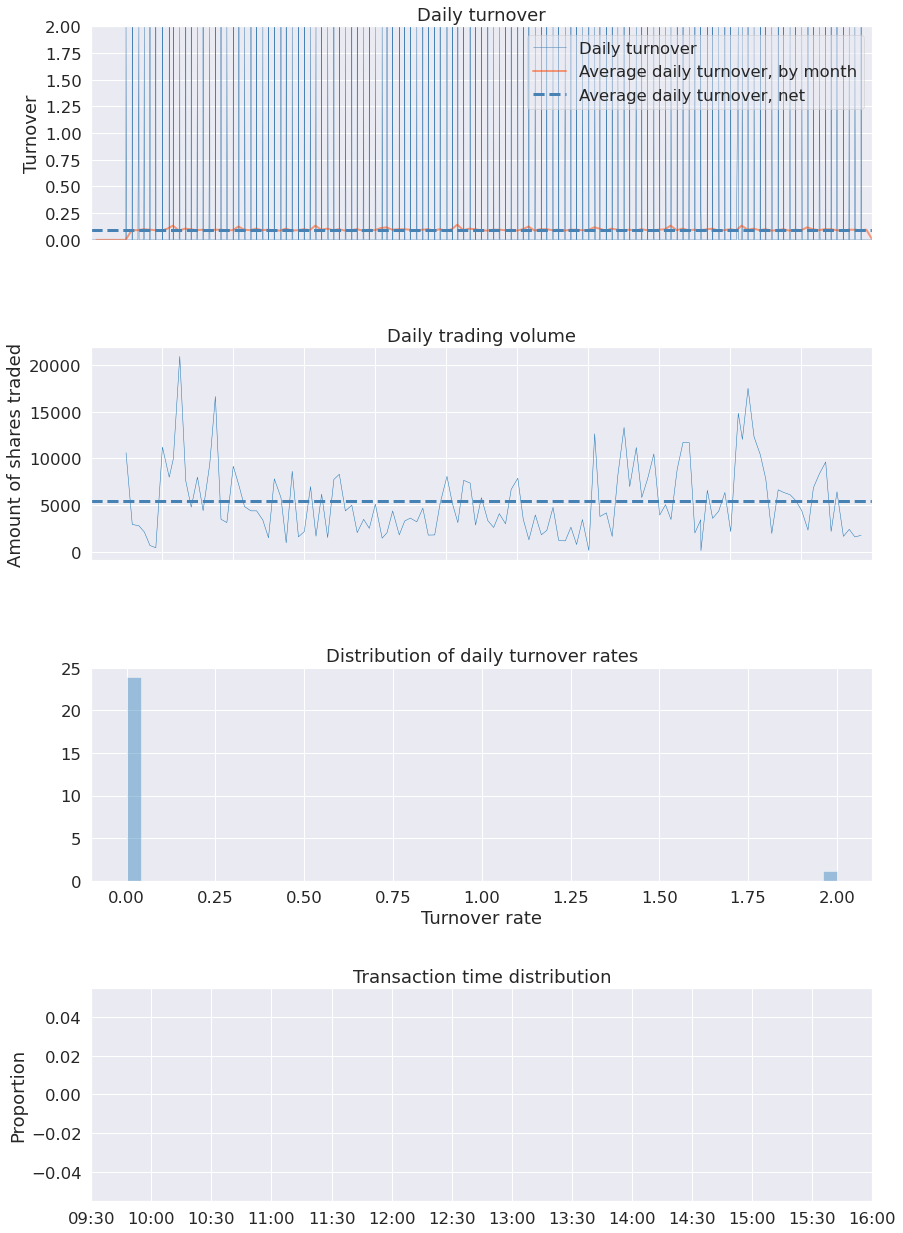

In [36]:
import pyfolio as pf

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions)